- 프로젝트: 이탈 예측 모델 개발
    - 모델의 전반적인 컨셉 -> 전학년 별 이탈 예측, 학년 별 이탈 예측, 성별에 따른 이탈 예측, 재구매 이력에 따른 이탈 예측 등
    - 활용 데이터 설명
    - 예측 모델(linear, logistic, DCT, Xgboost, LGBM 등등)
    - 성능 지표를 통한 결과 설명
    
#성별과 당월 학습시간평균, 획득점수 평균에 따른 이탈/미이탈 여부
    

system_id : 시스템 상 id
grade_sect_cd : 학년 (1~6 학년)
mbr_sex_cd : 성별
tmon_pchrg_lrn_dcnt : 당월 유료 학습 일 수
acmlt_pchrg_lrn_dcnt: 누적 유료 학습 일 수(성숙도)
acmlt_bilclct_amt : 누적 수금액
correct_rate_avg : 당월 획득 점수 평균
learning_time_avg : 당월 학습 시간 평균
media_action_cnt_sum : 미디어 콘텐츠 내 동영상 행동(시청) 횟수 총합
non_video_viewed_cnt_sum : 미디어 콘텐츠 내 미시청 행동 횟수 총합
get_mm_point_sum : 당월 획득 포인트 합 (사용 x)
label : 이탈,미이탈 여부
re_purch : 구매,재구매

In [1]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from lightgbm import plot_importance
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

churn_data = pd.read_csv('./data/churn_data.csv')

 성별 학습시간 당월 획득점수 평균이 이탈에 영향을 미치
사용할 것 : 성별, 학습시간,당월 획득 점수 평균
mbr_sex_cd : 성별
learning_time_avg : 학습시간 평균
correct_rate_avg : 획득점수 평균

# 전처리
----------------------------------------------------------

In [2]:
churn_data[churn_data['tmon_pchrg_lrn_dcnt']>churn_data['acmlt_pchrg_lrn_dcnt']].count()

number                      0
system_id                   0
grade_sect_cd               0
mbr_sex_cd                  0
tmon_pchrg_lrn_dcnt         0
acmlt_pchrg_lrn_dcnt        0
acmlt_bilclct_amt           0
correct_rate_avg            0
learning_time_avg           0
media_action_cnt_sum        0
non_video_viewed_cnt_sum    0
get_mm_point_sum            0
label                       0
re_purch                    0
dtype: int64

누적 유료학습일수가 당월 유료학습일 수보다 많은 날은 없음

In [3]:
churn_data[churn_data['tmon_pchrg_lrn_dcnt']>31].count()

number                      0
system_id                   0
grade_sect_cd               0
mbr_sex_cd                  0
tmon_pchrg_lrn_dcnt         0
acmlt_pchrg_lrn_dcnt        0
acmlt_bilclct_amt           0
correct_rate_avg            0
learning_time_avg           0
media_action_cnt_sum        0
non_video_viewed_cnt_sum    0
get_mm_point_sum            0
label                       0
re_purch                    0
dtype: int64

당월 유료학습일이 31 이상인 곳은 없음

초등학생 기준 학습시간 하루 최대 5시간으로 가정하여 이상치를 제거한다.

In [4]:
churn_data =churn_data[churn_data['learning_time_avg']<155]

churn_data =churn_data[churn_data['learning_time_avg']>0]

성별의 X라는 값을 제거

In [5]:
churn_data['mbr_sex_cd'].unique()

churn_data = churn_data[churn_data['mbr_sex_cd'] != 'X'].copy()

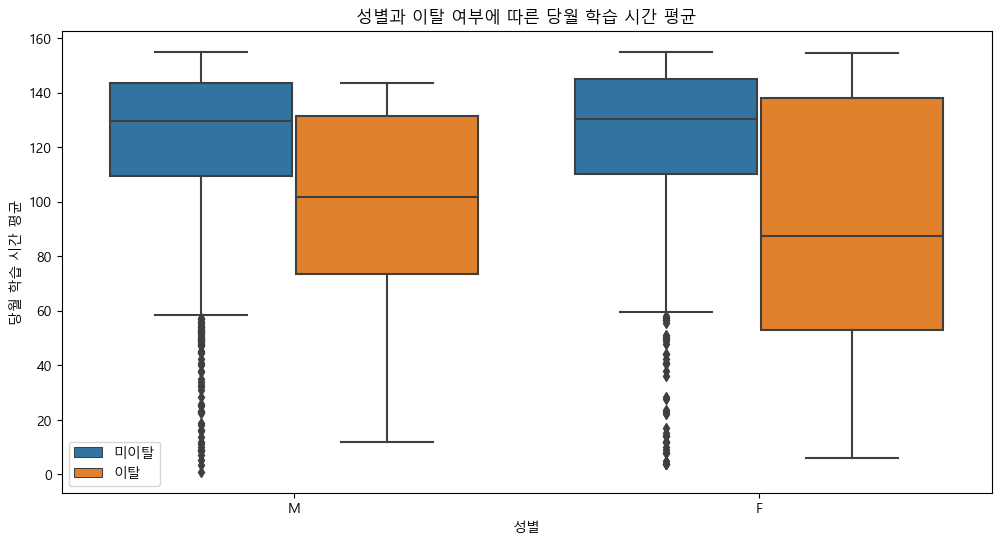

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 성별과 이탈 여부에 따른 학습 시간 평균을 박스 플롯으로 시각화
plt.rcParams['font.family'] ='Malgun Gothic'
plt.figure(figsize=(12, 6))
sns.boxplot(x='mbr_sex_cd', y='learning_time_avg', hue='label', data=churn_data)

plt.title('성별과 이탈 여부에 따른 당월 학습 시간 평균')
plt.xlabel('성별')
plt.ylabel('당월 학습 시간 평균')
handles, _= plt.gca().get_legend_handles_labels()
plt.legend(handles, ['미이탈', '이탈'])
plt.show()


이탈한 학생들 중 남학생이 평균 학습시간이 더 높게 나타난 것으로 보인다.

X 제거 후 범주형 변수인 mbr_sex_cd를 수치형으로 변환 

In [7]:
# 범주형 변수인 mbr_sex_cd를 수치형으로 변환 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(churn_data['mbr_sex_cd'])
churn_data['mbr_sex_cd']= encoder.transform(churn_data['mbr_sex_cd'])
churn_data

,number,system_id,grade_sect_cd,mbr_sex_cd,tmon_pchrg_lrn_dcnt,acmlt_pchrg_lrn_dcnt,acmlt_bilclct_amt,correct_rate_avg,learning_time_avg,media_action_cnt_sum,non_video_viewed_cnt_sum,get_mm_point_sum,label,re_purch
50,388,159983a9-a47f-41a9-ad70-2cbcc37b9861,G011,1,31.0,355.0,1177200.0,0.73,104.34,789.0,265.0,4890.0,0,False
81,657,17f34633-e3d1-4a02-9a8b-8b7e6708edd9,G011,1,31.0,149.0,595000.0,0.79,146.95,497.0,185.0,6312.0,0,False
104,825,8e6ed1b3-2f3b-419d-ad2e-eab25fd7ebdd,G011,0,29.0,265.0,1071000.0,0.89,138.23,144.0,57.0,223.0,0,False
145,1115,be94d21a-5f68-4f45-88d8-ae0f6e950fd6,G011,1,31.0,343.0,1308000.0,0.88,131.26,600.0,258.0,5278.0,0,False
171,1263,d52cef2a-2eed-4797-908f-0c82442719dd,G011,0,31.0,406.0,1526000.0,1.00,132.67,5.0,3.0,13.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59916,66476,78e12f9a-3fc3-4693-a2f2-2662d57aeda7,G016,1,31.0,370.0,1417000.0,0.86,95.65,432.0,246.0,2112.0,0,False
59919,66521,809966c9-9eaa-4019-a408-f85a66781e6b,G016,0,31.0,40.0,218000.0,0.80,114.09,295.0,101.0,12341.0,0,False
59944,66694,15ee1ba5-1b37-42eb-b2c3-f6039a0837db,G016,1,31.0,660.0,1738000.0,0.51,142.65,287.0,173.0,614.0,0,True
59983,66919,3419d6ca-064a-44a4-a572-13b6fc3fa69d,G016,0,31.0,482.0,1744000.0,0.71,150.38,529.0,281.0,1348.0,0,False


# X,y 설정
------------------------------------------------------

In [8]:
churn_data['mbr_sex_cd']= churn_data['mbr_sex_cd'].astype('float64')

X= churn_data[['mbr_sex_cd','learning_time_avg','correct_rate_avg']]
y= churn_data['label']

X_test,X_train,y_test,y_train = train_test_split(X,y,test_size=0.2,random_state=0)



In [9]:
# LGBMClassifier 모델 생성 및 학습
lgbm_model = LGBMClassifier(random_state=42,verbose=-1)
lgbm_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = lgbm_model.predict(X_test)

# 모델 성능 평가
acc = accuracy_score(y_test, y_pred)
pr, re, f1,_ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(' acc: {}, precision: {}, recall: {}, f1: {}'.format( acc, pr, re, f1))


 acc: 0.9809935205183585, precision: 0.0, recall: 0.0, f1: 0.0


In [10]:
print("[Train] 전체: {} , 이탈 : {}, 미이탈 : {}".format(len(X_train),y_train[y_train==1].shape[0],
                                                    y_train[y_train==0].shape[0] ))
print("[Test] 전체: {} , 이탈 : {}, 미이탈: {}".format(len(X_test),y_test[y_test==1].shape[0],
                                                    y_test[y_test==0].shape[0]) )

[Train] 전체: 579 , 이탈 : 10, 미이탈 : 569
[Test] 전체: 2315 , 이탈 : 30, 미이탈: 2285


In [11]:
from sklearn.metrics import confusion_matrix
cmtx= pd.DataFrame(confusion_matrix(y_test,y_pred,labels=[1,0]),
                  index=['실제:이탈(1)','실제:미이탈(0)'],
                  columns=['예측:이탈(1)','예측:미이탈(0)'])
cmtx

,예측:이탈(1),예측:미이탈(0)
실제:이탈(1),0,30
실제:미이탈(0),14,2271


이탈값이 측정되지않아 오버 샘플링하여 다시 측정하엿다.

In [12]:
from imblearn.over_sampling import SMOTE
X_train_over,y_train_over = SMOTE(random_state=12).fit_resample(X_train,y_train)
print(y_train_over.value_counts())

label
1    569
0    569
Name: count, dtype: int64


In [13]:
# 모델 재훈련
lgbm_model = LGBMClassifier(random_state=12)
lgbm_model.fit(X=X_train_over,y=y_train_over)

# 재예측
y_pred= lgbm_model.predict(X_test)

#재평가
acc = accuracy_score(y_test, y_pred)
pr, re, f1,_ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(' acc: {}, precision: {}, recall: {}, f1: {}'.format( acc, pr, re, f1))


[LightGBM] [Info] Number of positive: 569, number of negative: 569
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 1138, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
 acc: 0.9321814254859612, precision: 0.022556390977443608, recall: 0.1, f1: 0.03680981595092025


In [14]:
print("[Train] 전체: {} , 이탈 : {}, 미이탈 : {}".format(len(X_train_over),y_train_over[y_train_over==1].shape[0],
                                                    y_train_over[y_train_over==0].shape[0] ))
print("[Test] 전체: {} , 이탈 : {}, 미이탈: {}".format(len(X_test),y_test[y_test==1].shape[0],
                                                    y_test[y_test==0].shape[0]) )

[Train] 전체: 1138 , 이탈 : 569, 미이탈 : 569
[Test] 전체: 2315 , 이탈 : 30, 미이탈: 2285


In [15]:
from sklearn.metrics import confusion_matrix
cmtx= pd.DataFrame(confusion_matrix(y_test,y_pred,labels=[1,0]),
                  index=['실제:이탈(1)','실제:미이탈(0)'],
                  columns=['예측:이탈(1)','예측:미이탈(0)'])
cmtx

,예측:이탈(1),예측:미이탈(0)
실제:이탈(1),3,27
실제:미이탈(0),130,2155


오버 샘플링 결과 정확도는 약 93%로 높지만 정밀도,재현율,F1score가 낮게 나와 성능을 높히기 위해 하이퍼 마라미터를 설정하였습니다.

In [16]:
from sklearn.model_selection import GridSearchCV
lgbm_model = LGBMClassifier(verbose=-1)

# 하이퍼파라미터 그리드 설정
param_grid = {'num_leaves': [10,20,30],# num_leaves 후보 값들
              'learning_rate':[0.01,0.05,0.1], # learning_rate 후보 값들 (학습정도)
              'max_depth':[3,5,7], # max_depth 후보 값들
              'min_child_samples': [10,20,30] # min_child_samples의 후보 값들 샘플 양
}

# GridSearchCV 객체 생성
grid_search= GridSearchCV(estimator=lgbm_model,param_grid=param_grid)

# 그리드 서치 수행
grid_search.fit(X_train_over,y_train_over)
# 최적의 하이퍼파라미터
print('Best Parameters : ', grid_search.best_params_)
# 최적의 하이퍼파라미터로 학습된 모델 가져오기
best_model = grid_search.best_estimator_
# 예측 수행

y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
pr, re, f1,_ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(' acc: {}, precision: {}, recall: {}, f1: {}'.format( acc, pr, re, f1))

Best Parameters :  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 30}
 acc: 0.9282937365010799, precision: 0.027777777777777776, recall: 0.13333333333333333, f1: 0.04597701149425287


In [17]:
print("[Train] 전체: {} , 이탈 : {}, 미이탈 : {}".format(len(X_train_over),y_train_over[y_train_over==1].shape[0],
                                                    y_train_over[y_train_over==0].shape[0] ))
print("[Test] 전체: {} , 이탈 : {}, 미이탈: {}".format(len(X_test),y_test[y_test==1].shape[0],
                                                    y_test[y_test==0].shape[0]) )

[Train] 전체: 1138 , 이탈 : 569, 미이탈 : 569
[Test] 전체: 2315 , 이탈 : 30, 미이탈: 2285


In [18]:
cmtx= pd.DataFrame(confusion_matrix(y_test,y_pred,labels=[1,0]),
                  index=['실제:이탈(1)','실제:미이탈(0)'],
                  columns=['예측:이탈(1)','예측:미이탈(0)'])
cmtx

,예측:이탈(1),예측:미이탈(0)
실제:이탈(1),4,26
실제:미이탈(0),140,2145


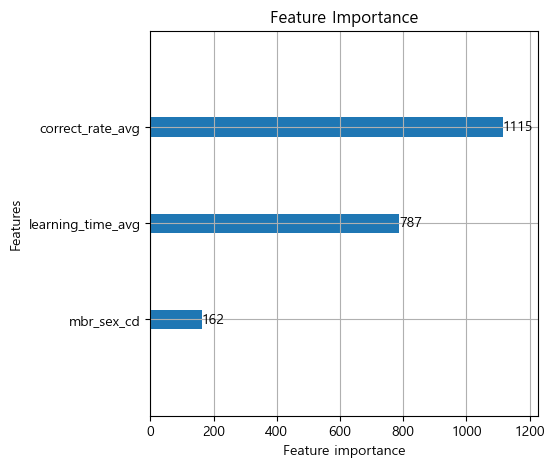

In [19]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
plot_importance(best_model, ax=ax)
plt.title("Feature Importance")
plt.show()

성별,당월 학습시간평균, 획득점수 평균에 따른 이탈 여부

학습시간 평균이 학습자의 이탈여부와 관계가 있다는 것을 알수 있다.

획득 점수 평균이 중요하게 작용하는것으로 보아 획득 점수가 낮은 학생들에게 점수를 올릴수 있는 프로그램을 만들어 이탈율을 줄일수 있다.